Osnabrück University - A&C: Computational Cognition (Summer Term 2019)

# Exercise Sheet 05: Eye tracking

## Introduction

This week's sheet should be solved and handed in at 14:00 at **Tuesday, May 28, 2019**. If you need help (and Google and other resources were not enough), feel free to contact your tutors. Please push your results to your Github group folder.

For this exercise sheet you will have 2 weeks and the sheet is also worth of 30 points. In this exercise sheet you will start to work with eye tracking data. Note that the data we will use here are not raw gaze data and contain coordinates of fixation points.

The dataset is distributed freely by a following study: [Wilming, N. Dryad](https://www.nature.com/articles/sdata2016126#data-citations). By clicking on the link in the section "Data Citations" you will get redirected to the page where you can download all the data openly distributed. Read below for description of each file.

##### necessary
*etdb_v1.0*: This is the main data file. The hdf5 file consists of all the fixation data and the metadata.  
*Read gaze data with python*: Python script to read hdf5 file as a dataframe.  
*Stimuli/i*: Zip file containing image stimuli used in the study. The encoding convention is same as in the dataframe.
##### optional
*Metadata*: This is the csv file giving overview of all studies.

In [1]:
#%pip install h5py # make sure to install h5py which is used in fixmat.py

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.stats.anova import *
from statsmodels.formula.api import ols
from datas.fixmat import *
import scipy.stats

## Assignment 0: Peer review for sheet 04 [3 pts]

Each group reviews the solutions of two other groups and give points according to the given point distribution considering the correctness of the solution. For this reviews the tutors will give you up to 3 points each week. Follow a distributed comment guidelines if you are unsure.

| * |Group 1|Group 2|Group 3|Group 4|Group 5|Group 6|Group 7|Group 8|Group 9|Group 10|Group 11|
| ------- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ----- | ------ | ------ |
| check solutions of group: | 5, 9 | 1, 6  | 4, 7  | 7, 2 | 2, 11 | 8, 3 | 3, 10  | 11, 1  | 10, 4  | 6, 8  | 9, 5   |


## Assignment 1: Checking the data distribution [9 pts]

### a) loading datasets [0 pts]
As with any other datasets, the first step is to get an idea of the dataset. Check the meta data and column of the dataframe.

In [3]:
# use a fixmat.py to load the hdf5 format data as a panda dataframe
df, meta = load('datas/etdb_v1.0.hdf5', "Baseline")

In [4]:
meta

{'# Fix.': 203772,
 '# Obs.': 48,
 'Age': '23.1 (19-28)',
 'Article': 15.0,
 'Categories': '7,8,10,11',
 'Disp. Size (degree)': '29x22',
 'Display': 'SM1100',
 'Display resolution (pixels)': '1280x960',
 'Eye Tracker': 'EL II',
 'ID': 3,
 'Img. Pos. (pixel)': '0,0',
 'Img. size (pixel)': '1280x960',
 'PPD': 45.6,
 'Sampling freq. (Hz)': '500 Hz',
 'Task': 'FV',
 'V. Dur.': '6s',
 'V. dist. (cm) ': 80,
 'Val. error (degrees)': 0.3}

In [5]:
df.columns

Index(['SUBJECTINDEX', 'category', 'dataset_nr', 'end', 'eye', 'filenumber',
       'fix', 'pupil', 'start', 'trial', 'x', 'y'],
      dtype='object')

### b) data cleaning [3 pts]
We want to clean the dataframe so that it is handy for us to work with it.
- How many fixations do we have per category? ```agg``` function might be helpful.
- categories are encoded using a number. Add a column to the dataframe that has approporiate string value for that category (e.g. code 11.0 to "Pink-noise"). The category names can be found on Figure 2 of the paper.
- since measurements lasted for 6 seconds, any fixation points that have a onset time before 0 sec and end time more than 6 sec are erroneous. Remove these rows.
- also remove all rows with any NaN values.
- add a column called ```duration``` and compute the duration of each fixation.
- It is known from previous literature that fixations typically last between 100 msec to 400 msec. Remove all rows with unrealistic  fixation duration.
- check how many data points got removed for each category. Let's hope that we didn't delete too many rows from a single category.
- count the number of fixations for each trial. To do this, you can use the aggregate method to count the number of rows for each category.
- print the mean duration and the mean number of fixation across all trials. Are they in a realistic range?

In [6]:
def clean_data(df: pd.DataFrame) -> pd.DataFrame:
    # Create intepretable category names
    df['category'] = df.category.map({
        7.0: "Natural",
        8.0: "Urban",
        10.0: "Fractals",
        11.0: "Pink-Noise"
    })

    # Count the number of fixations per category
    num_samples_per_category = df.groupby("category")['fix'].count()
    print("Samples per category: \n", num_samples_per_category, "\n\n")

    # Remove invalid samples
    df = df[(df.start >= 0) & (df.end <= 6000)]
    
    # Drop NaNs
    df.dropna(inplace=True)
    
    # Calculate duration and filter it for reliable ones
    df['duration'] = df.end - df.start
    df = df[(df.duration >= 100) & (df.duration <= 400)]

    # Print number of removed samples
    print("Number of removed samples:\n", num_samples_per_category - df.groupby("category")['fix'].count(), "\n\n")

    # Print number of trails
    print("Number of trials:\n", df.groupby(["category", "trial"]).count()['SUBJECTINDEX'], "\n\n")

    # Print global means - as they are in the expected range, they may soemwhat be realist
    print("Global means:\n", df[['duration', 'fix']].mean(), "\n\n")
    
    return df

df = clean_data(df)

Samples per category: 
 category
Fractals      52901
Natural       52338
Pink-Noise    41853
Urban         56680
Name: fix, dtype: int64 




c:\users\sarah\anaconda3\envs\acc\lib\site-packages\ipykernel_launcher.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
c:\users\sarah\anaconda3\envs\acc\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


Number of removed samples:
 category
Fractals      12979
Natural       12554
Pink-Noise    14603
Urban         11835
Name: fix, dtype: int64 


Number of trials:
 category  trial
Fractals  1.0      157
          2.0       93
          3.0      160
          4.0      172
          5.0      268
          6.0      117
          7.0      157
          8.0      151
          9.0      163
          10.0     153
          11.0     198
          12.0     183
          13.0     153
          14.0     275
          15.0      61
          16.0      87
          17.0     231
          18.0     214
          19.0     130
          20.0      92
          21.0     111
          22.0     128
          23.0     245
          24.0     234
          25.0     129
          26.0     138
          27.0     189
          28.0     105
          29.0     128
          30.0     241
                  ... 
Urban     226.0    176
          227.0     91
          228.0    197
          229.0    184
          230.0 

### c) visualizing data distribution [3 pts]
Are there any inter-subject difference and effect of different category in our data?
- plot the mean duration for each category (4 x-values) and the mean duration for each subject (48 x-values).

- plot the mean number of fixations for each category (4 x-values) and the mean number of fixation for each subject (48 x-values).

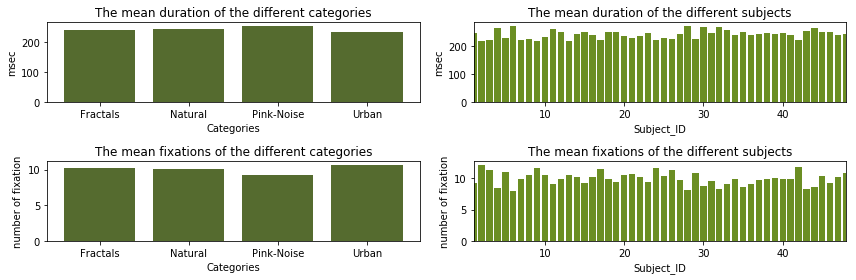

In [7]:
def plot_data_distribution(df: pd.DataFrame) -> pd.DataFrame:
    
    #selecting the mean for the categories and for the subjects
    mean_cat = df.groupby("category").mean()
    mean_sub = df.groupby("SUBJECTINDEX").mean()
    
    #creating the figure
    fig, axes = plt.subplots(nrows = 2, ncols = 2, figsize = (12,4)) 
  
    #creates the mean duration plot for the categories
    axes[0][0].set(title = "The mean duration of the different categories", xlabel = 'Categories', ylabel = 'msec')
    axes[0][0].bar( x = mean_cat.index, data = mean_cat, height = mean_cat["duration"], color = '#556B2F')
    
    #creates the mean duration plot for the subjects
    axes[0][1].set(title = "The mean duration of the different subjects", xlabel = 'Subject_ID', ylabel = 'msec',
                   xlim = (mean_sub.index[0],mean_sub.index[-1]))
    axes[0][1].bar( x = mean_sub.index, data = mean_sub, height = mean_sub["duration"], color = '#6B8E23')
    
    #creates the mean fixatiom plot for the categories
    axes[1][0].set(title = "The mean fixations of the different categories", xlabel = 'Categories', 
                   ylabel = 'number of fixation')
    axes[1][0].bar( x = mean_cat.index, data = mean_cat, height = mean_cat["fix"], color = '#556B2F')
    
    #creates the mean fixation plot for the subjects
    axes[1][1].set(title = "The mean fixations of the different subjects", xlabel = 'Subject_ID', ylabel = 'number of fixation',
                   xlim = (mean_sub.index[0],mean_sub.index[-1]))
    axes[1][1].bar( x = mean_sub.index, data = mean_sub, height = mean_sub["fix"], color = '#6B8E23')
    
    #print()
    
    #tight up the figure
    fig.tight_layout()

plot_data_distribution(df)

### d) normally distributed data [3 pts]
As ANOVA and lots of other statistical tests can be used only for normally distributed varaibles, it makes sense to find out whether the fixation duration and the number of fixations per trial is also normally distributed. This can be done with a Q-Q-Plot, which  is a graphical technique for determining if two data sets come from populations with a common distribution, in this case a normal distribution (for more information, klick [here](https://www.itl.nist.gov/div898/handbook/eda/section3/eda33o.htm)).
- make a Q-Q plot of the variable *fixation duration*. Is it approximately normally distributed?
- make a Q-Q plot of the variable *# fixation per trial*. Is it approximately normally distributed?

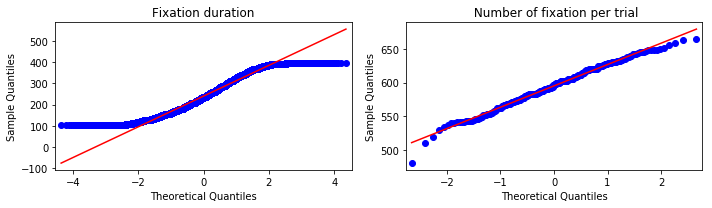

In [8]:
#get the varibales 
fix_duration = df["duration"]
fix_per_trial = df.groupby("trial")["fix"].count()

#creates the figure
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10,3))

#set the title for the plots
axes[0].set(title = "Fixation duration")
axes[1].set(title = " Number of fixation per trial")

#creates the qplot for fixation duration
prob = sm.ProbPlot(fix_duration,dist="norm")
prob.qqplot(line="r", ax=axes[0])

#creates the qplot for number of fixation per trial
prob = sm.ProbPlot(fix_per_trial,dist="norm")
prob.qqplot(line="r", ax=axes[1])

#thights the layout and shows the figure
fig.tight_layout()
plt.show()

I would say, that the fixation duration has not normal distriubiton, because it differs in the beginning and end from the reference line. At all I would say it differes in total about 1/3 of the line. Also the whole line is continous. 

Number of fixation per trial has a normal distriubition, because it differs not from the reference line, only some points. But that is not the major of the data

## Assignment 2: Hypothesis testing [3 pts]

### a) one way ANOVA [3 pts]
Now it's time to really prove our intuition. Test the following null hypotheses:  
$H01$: There is no difference in fixation duration across 4 different categories.  
$H02$: There is no difference in the number of fixations across 4 different categories.

What do you find?

In [9]:
# H01
# outcome   variable: fixation duration
# predictor variable: 4 different categories
h01 = ols('duration ~ category', data = df).fit()
table_h01 = anova_lm(h01, typ = 1)
print(table_h01)

                df        sum_sq       mean_sq           F         PR(>F)
category       3.0  6.918205e+06  2.306068e+06  431.192133  5.622037e-279
Residual  151797.0  8.118290e+08  5.348123e+03         NaN            NaN


In [10]:
# H02
# outcome   variable: number of fixations
# predictor variable: 4 different categories
h02 = ols('fix ~ category', data = df).fit()
table_h02 = anova_lm(h02, typ = 1)
print(table_h02)

                df        sum_sq       mean_sq           F         PR(>F)
category       3.0  3.568378e+04  11894.594050  415.497823  7.603614e-269
Residual  151797.0  4.345543e+06     28.627332         NaN            NaN


The first null hypothesis, H01, states that there is no difference in fixation duration across 4 different categories. The ANOVA-Test shows a PR(>F) smaller than the critical p (0.05), therefore we can reject the null hypothesis.

The second null hypothesis, H02, states that there is no difference in the number of fixations across 4 different categories. The ANOVA-Test shows a PR(>F) smaller than the critical p (0.05), therefore we can reject the null hypothesis. 


## Assignment 3: Binning [4 pts]

### a) distribution of # fixation [2 pts]
Now we would like to know if there's a difference in terms of fixation numbers at different time segment.
- make a histogram with x axis being the start time of fixation
- the bin size should be 1 sec. In total there would be 6 bins.
- average over all subjects and images, just make a one simple plot
- figure out mean fixation duration for each bin and print it


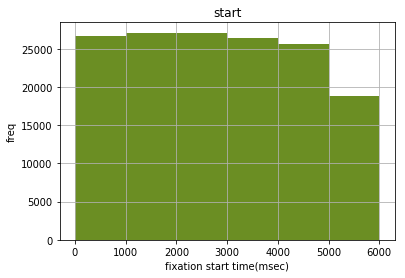

mean duration


,SUBJECTINDEX,category,dataset_nr,end,eye,filenumber,fix,pupil,start,trial,x,y,duration,neu
1,1.0,Pink-Noise,3.0,503.0,2.0,25.0,2.0,2872.182129,261.0,1.0,524.0,276.0,242.0,0.0
2,1.0,Pink-Noise,3.0,819.0,2.0,25.0,3.0,2452.396484,541.0,1.0,592.0,393.0,278.0,1.0
3,1.0,Pink-Noise,3.0,1103.0,2.0,25.0,4.0,2135.433594,865.0,1.0,367.0,339.0,238.0,1.0
4,1.0,Pink-Noise,3.0,1399.0,2.0,25.0,5.0,2007.327393,1145.0,1.0,196.0,364.0,254.0,1.0
6,1.0,Pink-Noise,3.0,2263.0,2.0,25.0,7.0,2346.299316,1977.0,1.0,687.0,356.0,286.0,2.0
7,1.0,Pink-Noise,3.0,2595.0,2.0,25.0,8.0,2303.531250,2301.0,1.0,823.0,285.0,294.0,2.0
8,1.0,Pink-Noise,3.0,2907.0,2.0,25.0,9.0,2606.652344,2637.0,1.0,688.0,238.0,270.0,3.0
10,1.0,Pink-Noise,3.0,3563.0,2.0,25.0,11.0,2309.188965,3433.0,1.0,469.0,380.0,130.0,3.0
11,1.0,Pink-Noise,3.0,4083.0,2.0,25.0,12.0,2646.744385,3717.0,1.0,534.0,431.0,366.0,4.0
12,1.0,Pink-Noise,3.0,4279.0,2.0,25.0,13.0,2757.007324,4101.0,1.0,542.0,414.0,178.0,4.0


In [13]:

fig, ax = plt.subplots()

# plot the average fixation duration over 6 time intervalls  
counts, bins, bars = ax.hist(df['start'], bins =[0,1000,2000,3000,4000,5000,6000],color ='#6B8E23')
plt.grid(axis='both')
ax.set(title='start', 
        ylabel='freq', 
        xlabel='fixation start time(msec)')

plt.show()

df = df.assign(neu = round(df['start']/1000))
df['neu'] = df['neu'].astype('category')
#df_avg = df.groupby('neu').mean().reset_index()

print('mean duration')
#print(df_avg['duration'])
df

### b) leftward bias [2 pts]
If you took Action & Cognition I, you have probably heard about the leftward bias in human's fixation behavior. It is known that people tend to look more at the left visual field for the initial first second. Check whether this holds for our dataset as well.
- make a pointplot with x-axis as the x-coordinate of each fixation point and y-axis as the time bin to which the fixation point belongs to.
- mark the confidence interval around each point.
- make a vertical line at middle point of the x values. The x-coordinate of the fixation point in the data is based on the coordinate system using the display resolution. You can find out the information about display resolution by taking a look at the meta data.

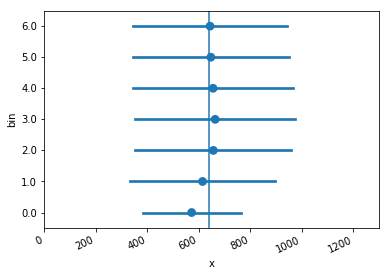

In [23]:
# TODO: Change Scale

#confidence_interval =stats.norm.interval(0.95, loc = df_avg['x'], scale  = 100)
#fig = plt.figure(figsize = (10,10))
#print(confidence_interval)

#sns.pointplot(df_avg['x'],df_avg[ 'y'], join  = False)
#g.set(ylabel = 'bin', xlim = (-0.5,10.5))
xticks = plt.xticks(rotation=25, ha = "right")



# TODO: Confidence Interval
#for c in confidence_interval:
 #   c_t = zip()

#plt.errorbar(df_avg['x'],df_avg['neu'],xerr =confidence_interval )

#ax = sns.pointplot(x=confidence_interval,y = df_avg['neu'], join  = False)
# TODO: Vertical line

g = sns.pointplot(x='x', y='neu', data=df, join  = False, ci = 'sd')
g.set(xlim  = (0,1300), ylabel = 'bin')
g.invert_yaxis()
plt.axvline(x = 640)
#axline
#df_avg

## Assignment 4: Heatmap [4 pts]
Now let's use heatmap to visualize which part of pictures is fixated for how long. It would be also good to know if there's a difference between categories.
- make a heatmap for data consisting of each categories and then averaged across all data.
- mark a central point in the plot.
- you can use ```numpy.histogram2d``` to compute a bi-dimensional histogram.
- then you can use ```pyplot.imshow``` to plot these histogram.
- don't forget to use the parameter ```extent``` to control for the bounding box to which the image should fit in.
- if you want to use other functions that's surely fine as well.

In [ ]:
def draw_heatmap(plot, name: str, x_data, y_data, resolution: int = 120):
    # Generate the heatmap
    heatmap, hist_x, hist_y = np.histogram2d(x_data, y_data, bins=resolution)
    extent = (hist_x[0], hist_x[-1], hist_y[0], hist_y[-1])
    
    # Show the heatmap
    plot.imshow(heatmap.T, extent=extent, origin='lower')
    plot.set_title(name)
    
# Grab the categoreis and plots
categories = df["category"].unique()
fig, axes = plt.subplots(nrows=1, ncols=len(categories) + 1, figsize=(18, 16))

# Draw one plot for each category
for ax, category in zip(axes, categories):
    # Select the category and plot it
    selection = df[df["category"] == category]
    draw_heatmap(ax, category, selection['x'], selection['y'])

# Draw a heatmap for all data
draw_heatmap(axes[-1], "All", df['x'], df['y'])

# Show the heatmaps
fig.show()

## Assignment 5: Scanpath [5 pts]
We want to know whether different scan behaviour is used when viewing images of different categories. Scanpath is a path followed by the eyes when viewing a stimulus. Scanpaths are useful for analyzing cognitive intent, interest, and salience. It has an advantage to a heatmap because the information about temporal structure of viewing behaviour can be plotted.
- make four plots, one for each category.
- randomely choose one trial for which you will plot a scanpath.
- mark fixation points based on the x-y coordinates.
- plot the *saccade path* from one fixation point to another one.
- make sure that the order of fixation can be read out from the plot. E.g. earlier fixations could have a light color whereas later fixations could have dark colors.
- also include information about the duration of each fixation. One way to do it is the use the size of the fixation marker.
- plot the background image superimposed with the scanpath. 

In [ ]:
import random

# Grab the categoreis and plots
categories = df["category"].unique()
fig, axes = plt.subplots(nrows=len(categories)-2, ncols=2, figsize=(16, 16))

for ax, category in zip(axes, categories):
    # Select the category and plot it
    selection = df[df["category"] == category]
    
    # Select a random trial
    trial = random.choice(selection['trial'].unique())
    selection = selection[selection["trial"] == trial]
    
    # Select a random subject
    subject = random.choice(selection['SUBJECTINDEX'].unique())
    selection = selection[selection["SUBJECTINDEX"] == subject]
    
    # Create different colors for timing
    colors = list(range(len(selection)))
    cmap = matplotlib.cm.get_cmap('OrRd')
    normalizer = matplotlib.colors.Normalize(vmin=0, vmax=colors[-1])
    
    # Size normalizer
    size_normalizer = matplotlib.colors.Normalize(
        vmin=selection['duration'].min(), 
        vmax=selection['duration'].max()
    )
    
    # Plot the lines
    ax.plot(selection['x'], selection['y'], "-", linewidth=2, color="black")
    
    # Plot the points
    ax.scatter(
        x=selection['x'],
        y=selection['y'],
        c=[cmap(normalizer(color)) for color in colors],
        s=[size_normalizer(duration) * 100 + 50  for duration in selection["duration"]]
    )
    
    # Add the color bar
    cax, _ = matplotlib.colorbar.make_axes(ax)
    _ = matplotlib.colorbar.ColorbarBase(cax, cmap=cmap, norm=normalizer)

    # TODO: SHOW IMAGES IN BACKGROUND
    # TODO: ENSURE BOTH AXIS ARE EQUAL

fig.show()

# Citation
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) An extensive dataset of eye movements during viewing of complex images. Scientific Data 4: 160126. https://doi.org/10.1038/sdata.2016.126  
Wilming N, Onat S, Ossandón J, Acik A, Kietzmann TC, Kaspar K, Gameiro RR, Vormberg A, König P (2017) Data from: An extensive dataset of eye movements during viewing of complex images. Dryad Digital Repository. https://doi.org/10.5061/dryad.9pf75